In [2]:
import pandas as pd
import numpy as np

channels = pd.read_excel("../data/tg_channels.xlsx")
df = pd.read_parquet("../data/dataset_tg_economic.parquet")[["message_id", "id_channel", "message", "date", "viral_final", "is_economic", "topic"]]

/home/mlcore/conda/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
print(df.shape)
df.head()

(44760, 7)


,message_id,id_channel,message,date,viral_final,is_economic,topic
0,00027151-a524-4d93-a820-116398fb81bb,3,"Европа делает ""самоубийственное движение"", ког...",2025-04-07 11:53:51,0.406649,False,None
1,0003b835-cf4a-43ff-b155-a144cf56b7f8,3,Верховный суд Ингушетии отправил под арест быв...,2025-07-29 20:55:09,0.445509,False,None
2,0005535a-74a9-4cb9-853f-ce04612d2f94,3,Свыше миллиона детей пойдут в первый класс в э...,2025-04-01 13:53:43,0.396754,False,None
3,0007e2f8-787d-404f-91ff-e2582096a4a7,18,Сербия согласна поддержать санкции Евросоюза п...,2025-07-26 07:01:09,0.703622,True,Санкции и геополитика
4,000884a5-8291-4ec1-805f-ac131112aaf7,6,Китайский рынок акций упал сильнее всего с апр...,2025-09-04 10:16:56,0.680369,True,Рынки капитала


In [4]:
def attach_channel_w(
    df: pd.DataFrame,
    channels_df: pd.DataFrame,
    news_id_col: str = "id_channel",
    chan_id_col: str = "id",
    subs_col: str = "subscribers",
    weight_col: str = "channel_w",) -> pd.DataFrame:
    ch = channels_df[[chan_id_col, subs_col]].copy()
    ch[chan_id_col] = pd.to_numeric(ch[chan_id_col], errors="coerce").astype("Int64")
    ch[subs_col] = pd.to_numeric(ch[subs_col], errors="coerce").fillna(0).astype(float)
    id2subs = dict(zip(ch[chan_id_col], ch[subs_col]))

    out = df.copy()
    out[news_id_col] = pd.to_numeric(out[news_id_col], errors="coerce").astype("Int64")

    subs = out[news_id_col].map(id2subs).fillna(0.0).to_numpy(dtype=np.float32)
    log_subs = np.log1p(subs)

    mn, mx = float(log_subs.min()), float(log_subs.max())
    if mx > mn:
        w = (log_subs - mn) / (mx - mn)
    else:
        w = np.zeros_like(log_subs, dtype=np.float32)

    out[weight_col] = w.astype(np.float32)
    return out


In [5]:
ch_map = (channels[["id", "name"]]
          .dropna()
          .assign(id=lambda x: pd.to_numeric(x["id"], errors="coerce"))
          .dropna(subset=["id"])
          .assign(id=lambda x: x["id"].astype(int))
          .set_index("id")["name"]
          .to_dict())

df = df.copy()
df["id_channel"] = pd.to_numeric(df["id_channel"], errors="coerce")
df["channel_name"] = df["id_channel"].map(ch_map).fillna(df["id_channel"].astype("Int64").astype(str))
df = attach_channel_w(df, channels)

In [6]:
import re
import numpy as np
import pandas as pd

def clean_news_text(t: str) -> str:
    t = t or ""
    t = re.sub(r"#\w+", " ", t)
    t = re.sub(r"[⚡️📈📉🇷🇺✅❗️🔥⬛ ⬜ ⚫ ⚪🔹]+", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def ensure_datetime(df: pd.DataFrame, col: str = "date") -> pd.DataFrame:
    d = df.copy()
    d[col] = pd.to_datetime(d[col], utc=True, errors="coerce")
    d = d.dropna(subset=[col])
    d["date_day"] = d[col].dt.floor("D")
    return d

df = ensure_datetime(df, "date")
df["message_id"] = df["message_id"].astype(str)
df["message"] = df["message"].fillna("").astype(str).map(clean_news_text)

In [7]:
df.head()

,message_id,id_channel,message,date,viral_final,is_economic,topic,channel_name,channel_w,date_day
0,00027151-a524-4d93-a820-116398fb81bb,3,"Европа делает ""самоубийственное движение"", ког...",2025-04-07 11:53:51+00:00,0.406649,False,None,Риа Новости,1.000000,2025-04-07 00:00:00+00:00
1,0003b835-cf4a-43ff-b155-a144cf56b7f8,3,Верховный суд Ингушетии отправил под арест быв...,2025-07-29 20:55:09+00:00,0.445509,False,None,Риа Новости,1.000000,2025-07-29 00:00:00+00:00
2,0005535a-74a9-4cb9-853f-ce04612d2f94,3,Свыше миллиона детей пойдут в первый класс в э...,2025-04-01 13:53:43+00:00,0.396754,False,None,Риа Новости,1.000000,2025-04-01 00:00:00+00:00
3,0007e2f8-787d-404f-91ff-e2582096a4a7,18,Сербия согласна поддержать санкции Евросоюза п...,2025-07-26 07:01:09+00:00,0.703622,True,Санкции и геополитика,Экономика,0.009202,2025-07-26 00:00:00+00:00
4,000884a5-8291-4ec1-805f-ac131112aaf7,6,Китайский рынок акций упал сильнее всего с апр...,2025-09-04 10:16:56+00:00,0.680369,True,Рынки капитала,Forbes Russia,0.182985,2025-09-04 00:00:00+00:00


In [9]:
from rank_bm25 import BM25Okapi

def tokenize_ru(text: str):
    text = text.lower()
    text = re.sub(r"[^0-9a-zа-яё\s]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.split()

corpus_tok = [tokenize_ru(t) for t in df["message"].tolist()]
bm25 = BM25Okapi(corpus_tok)

In [12]:
from sentence_transformers import SentenceTransformer

MODEL_NAME = "intfloat/multilingual-e5-large" 
encoder = SentenceTransformer(MODEL_NAME, device="cuda")  
texts = df["message"].tolist()
doc_inputs = ["passage: " + t for t in texts]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [13]:
# E_docs = encoder.encode(
#     doc_inputs,
#     batch_size=64,
#     show_progress_bar=True,
#     normalize_embeddings=True,
# ).astype(np.float32)

In [14]:
# import faiss

# dim = E_docs.shape[1]
# index = faiss.IndexFlatIP(dim)      
# index.add(E_docs)

In [15]:
# # save
# from pathlib import Path
# import numpy as np
# import pandas as pd
# import faiss
# import pickle

# OUT = Path("indexes")
# OUT.mkdir(parents=True, exist_ok=True)

# #rowmap
# rowmap = df[["message_id","date","date_day","id_channel","channel_name"]].copy()
# rowmap.to_parquet(OUT / "rowmap.parquet", index=False)

# np.save(OUT / "E_docs_e5_large.npy", E_docs)

# faiss.write_index(index, str(OUT / "faiss_e5_large.index"))

# with open(OUT / "bm25_corpus_tok.pkl", "wb") as f:
#     pickle.dump(corpus_tok, f)


In [16]:
# load
from pathlib import Path
import numpy as np
import pandas as pd
import faiss
import pickle

INP = Path("indexes")

rowmap = pd.read_parquet(INP / "rowmap.parquet")

E_docs = np.load(INP / "E_docs_e5_large.npy")
index = faiss.read_index(str(INP / "faiss_e5_large.index"))

with open(INP / "bm25_corpus_tok.pkl", "rb") as f:
    corpus_tok = pickle.load(f)

from rank_bm25 import BM25Okapi
bm25 = BM25Okapi(corpus_tok)


In [17]:
assert len(rowmap) == E_docs.shape[0]
assert len(rowmap) == index.ntotal

In [18]:
# %% [Cell 1] Imports + small helpers
import numpy as np
import pandas as pd

from typing import Optional, Union, Callable
import re
import json


def snippet(t: str, n: int = 1000) -> str:
    return (t or "")[:n]


def _topk_indices_from_scores(scores: np.ndarray, k: int) -> np.ndarray:
    k = min(k, len(scores))
    if k <= 0:
        return np.array([], dtype=int)
    if k == len(scores):
        idx = np.argsort(-scores)
    else:
        idx = np.argpartition(-scores, k - 1)[:k]
        idx = idx[np.argsort(-scores[idx])]
    return idx.astype(int)


In [19]:
# %% [Cell 2] Dense retrieval (FAISS) + time utilities

def dense_candidates_faiss(index, encoder, query: str, topN: int = 500):
    qv = encoder.encode(
        ["query: " + query],
        normalize_embeddings=True,
        show_progress_bar=False
    ).astype(np.float32)
    scores, idx = index.search(qv, topN)
    return idx[0].astype(int), scores[0].astype(np.float32)


def _compute_time_arrays(df: pd.DataFrame, rowpos: np.ndarray, anchor_date, date_col: str):
    ad = pd.to_datetime(anchor_date, utc=True).normalize()
    dts = pd.to_datetime(df.loc[rowpos, date_col], errors="coerce", utc=True).dt.normalize()
    age = (ad - dts).dt.days.to_numpy(dtype=np.float32)
    age = np.where(np.isfinite(age), age, 1e9).astype(np.float32)
    age = np.where(age < 0, 1e9, age).astype(np.float32)
    return dts, age


def _time_rank_from_age(age_days: np.ndarray) -> np.ndarray:
    order = np.argsort(age_days, kind="stable")
    rank = np.empty_like(order, dtype=np.int32)
    rank[order] = np.arange(1, len(order) + 1, dtype=np.int32)
    return rank


In [20]:
# %% [Cell 3] RRF hybrid retrieval (returns candidate pool; includes dense_score & bm25_score)

def hybrid_retrieve_rrf(
    df: pd.DataFrame,
    index,
    encoder,
    bm25,
    tokenize_fn: Callable[[str], list],
    query: str,
    k: Optional[int] = None,            # <- default None: return ALL candidates in the union
    topN_each: int = 500,
    k_rrf: int = 60,
    w_dense: float = 1.0,
    w_bm25: float = 1.0,
    anchor_date: Union[str, pd.Timestamp, None] = None,
    date_col: str = "date_day",
    max_window_days: Optional[int] = 365,
    w_time: float = 0.5,
    w_channel: Optional[float] = None,
    channel_w_col: str = "channel_w",
    # optional viral
    w_viral: Optional[float] = None,
    viral_col: str = "viral_final",
) -> pd.DataFrame:
    # ---- allowed mask by time window
    if anchor_date is not None:
        ad = pd.to_datetime(anchor_date, utc=True).normalize()
        if date_col not in df.columns:
            raise KeyError(f"date_col='{date_col}' not found in df.columns")
        dts_all = pd.to_datetime(df[date_col], errors="coerce", utc=True).dt.normalize()
        allowed = (dts_all <= ad)
        if max_window_days is not None:
            age_all = (ad - dts_all).dt.days
            allowed &= (age_all >= 0) & (age_all <= int(max_window_days))
        allowed_np = allowed.to_numpy(dtype=bool)
    else:
        allowed_np = None

    # ---- dense
    d_idx, d_sc = dense_candidates_faiss(index, encoder, query, topN=topN_each)
    if allowed_np is not None and len(d_idx) > 0:
        keep_mask = allowed_np[d_idx]
        d_idx = d_idx[keep_mask]
        d_sc = d_sc[keep_mask]

    dense_rank = {int(rowpos): r for r, rowpos in enumerate(d_idx, start=1)}
    dense_score = {int(rowpos): float(sc) for rowpos, sc in zip(d_idx, d_sc)}

    # ---- bm25 optional
    bm_scores = None
    bm_rank = {}
    if bm25 is not None:
        bm_scores = bm25.get_scores(tokenize_fn(query)).astype(np.float32)
        if allowed_np is not None:
            bm_scores[~allowed_np] = -np.inf
        b_idx = _topk_indices_from_scores(bm_scores, topN_each)
        bm_rank = {int(rowpos): r for r, rowpos in enumerate(b_idx, start=1)}

    # ---- union
    union = np.array(sorted(set(dense_rank) | set(bm_rank)), dtype=int)
    if len(union) == 0:
        return df.iloc[[]].copy().reset_index(drop=True)

    # ---- rrf
    rrf = np.zeros(len(union), dtype=np.float32)
    for j, rowpos in enumerate(union):
        if rowpos in dense_rank:
            rrf[j] += w_dense / (k_rrf + dense_rank[rowpos])
        if rowpos in bm_rank:
            rrf[j] += w_bm25 / (k_rrf + bm_rank[rowpos])

    # ---- time rank add-on
    rank_time = None
    if anchor_date is not None and w_time and len(union) > 0:
        _, age = _compute_time_arrays(df, union, anchor_date, date_col)
        rank_time = _time_rank_from_age(age)
        rrf = rrf + (w_time / (k_rrf + rank_time.astype(np.float32)))

    # ---- order by rrf desc
    order = np.argsort(-rrf)
    union = union[order]
    rrf = rrf[order]
    if rank_time is not None:
        rank_time = rank_time[order]

    out = df.iloc[union].copy()
    out["_rowpos"] = union
    out["score_rrf"] = rrf

    # ranks
    out["rank_dense"] = out["_rowpos"].map(lambda rp: dense_rank.get(int(rp), np.nan))
    out["rank_bm25"] = out["_rowpos"].map(lambda rp: bm_rank.get(int(rp), np.nan))

    # scores (for semantic thresholding)
    out["dense_score"] = out["_rowpos"].map(lambda rp: dense_score.get(int(rp), np.nan))
    if bm_scores is None:
        out["bm25_score"] = np.nan
    else:
        out["bm25_score"] = out["_rowpos"].map(lambda rp: float(bm_scores[int(rp)]) if np.isfinite(bm_scores[int(rp)]) else -np.inf)

    # time info
    if anchor_date is not None:
        doc_day, age = _compute_time_arrays(df, union, anchor_date, date_col)
        out["doc_day"] = doc_day.dt.tz_localize(None)
        out["age_days"] = age
        if rank_time is not None:
            out["rank_time"] = rank_time

    # channel bias (optional)
    if channel_w_col in out.columns:
        if w_channel is None:
            w_channel = 0.10 * float(np.std(out["score_rrf"].to_numpy(dtype=np.float32)) or 1.0)
        out["score_rrf"] = out["score_rrf"] + float(w_channel) * out[channel_w_col].astype(np.float32)

    # viral bias (optional, small)
    if viral_col in out.columns:
        gamma = 5.0
        v = out[viral_col].astype(np.float32).to_numpy()
        v = np.clip(v, 0.0, 1.0) ** gamma
        
        if w_viral is None:
            w_viral = 0.5 * float(np.std(out["score_rrf"].to_numpy(np.float32)) or 1.0)
        
        out["score_rrf"] = out["score_rrf"] + float(w_viral) * v


    out = out.sort_values("score_rrf", ascending=False)

    if k is None:
        return out.reset_index(drop=True)
    return out.head(int(k)).reset_index(drop=True)


In [21]:
# %% [Cell 4] "разумный гибрид" semantic filter: dense_hi OR (dense_lo AND bm25_lo)

def semantic_filter_reasonable(
    cand: pd.DataFrame,
    *,
    tau_sem_hi: float,
    tau_sem_lo: float,
    tau_bm25_lo: float,
    dense_col: str = "dense_score",
    bm25_col: str = "bm25_score",
) -> pd.DataFrame:
    """
    Keep doc if:
      dense_score >= tau_sem_hi
      OR
      (dense_score >= tau_sem_lo AND bm25_score >= tau_bm25_lo)

    Notes:
    - Works even if bm25_score is NaN (treated as -inf).
    - Returns possibly empty DF.
    """
    if cand is None or len(cand) == 0:
        return cand

    if dense_col not in cand.columns:
        raise KeyError(f"'{dense_col}' not found in candidates (did you run updated retrieval?)")

    # missing bm25 -> treat as -inf so second branch won't fire
    dense = cand[dense_col].astype(np.float32).to_numpy()
    bm25  = cand[bm25_col].astype(np.float32).to_numpy() if bm25_col in cand.columns else np.full(len(cand), -np.inf, np.float32)

    dense = np.where(np.isfinite(dense), dense, -np.inf).astype(np.float32)
    bm25  = np.where(np.isfinite(bm25),  bm25,  -np.inf).astype(np.float32)

    keep_mask = (dense >= float(tau_sem_hi)) | ((dense >= float(tau_sem_lo)) & (bm25 >= float(tau_bm25_lo)))
    out = cand.loc[keep_mask].copy()
    out.reset_index(drop=True, inplace=True)
    return out


In [22]:
df["date_day"].min(), df["date_day"].max()

(Timestamp('2025-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2025-09-04 00:00:00+0000', tz='UTC'))

In [23]:
# %% [Cell 5] Model init (your judge LLM)

from transformers import AutoTokenizer, AutoConfig
from vllm import LLM
import torch

MODEL = "Qwen/Qwen2.5-14B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)

cfg = AutoConfig.from_pretrained(MODEL, trust_remote_code=True)
native_ctx = getattr(cfg, "max_position_embeddings", None)
print("GPU:", torch.cuda.get_device_name(0))
print("VRAM(GB):", round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 1))
print("Model max_position_embeddings:", native_ctx)

MAX_MODEL_LEN = 19200

model = LLM(
    model=MODEL,
    dtype="bfloat16",
    max_model_len=MAX_MODEL_LEN,
    gpu_memory_utilization=0.88
)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

GPU: NVIDIA A100-SXM4-80GB
VRAM(GB): 79.3
Model max_position_embeddings: 32768
INFO 01-21 23:02:00 [utils.py:263] non-default args: {'dtype': 'bfloat16', 'max_model_len': 19200, 'gpu_memory_utilization': 0.88, 'disable_log_stats': True, 'model': 'Qwen/Qwen2.5-14B-Instruct'}
INFO 01-21 23:02:12 [model.py:530] Resolved architecture: Qwen2ForCausalLM
INFO 01-21 23:02:12 [model.py:1545] Using max model len 19200
INFO 01-21 23:02:12 [scheduler.py:229] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 01-21 23:02:12 [vllm.py:630] Asynchronous scheduling is enabled.
INFO 01-21 23:02:12 [vllm.py:637] Disabling NCCL for DP synchronization when using async scheduling.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

WARNING 01-21 23:02:13 [system_utils.py:136] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
(EngineCore_DP0 pid=804) INFO 01-21 23:02:21 [core.py:97] Initializing a V1 LLM engine (v0.14.0) with config: model='Qwen/Qwen2.5-14B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-14B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=19200, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, enable_return_routed_experts=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, d

(EngineCore_DP0 pid=804) /home/mlcore/conda/lib/python3.10/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:174: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=804) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=804)   warnings.warn(


(EngineCore_DP0 pid=804) INFO 01-21 23:02:28 [cuda.py:351] Using FLASH_ATTN attention backend out of potential backends: ('FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION')
(EngineCore_DP0 pid=804) INFO 01-21 23:04:28 [weight_utils.py:510] Time spent downloading weights for Qwen/Qwen2.5-14B-Instruct: 118.790526 seconds


Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:01,  3.59it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.84it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.54it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:02,  1.41it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:03<00:02,  1.37it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:04<00:01,  1.33it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.31it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:05<00:00,  1.29it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:05<00:00,  1.40it/s]
(EngineCore_DP0 pid=804) 


(EngineCore_DP0 pid=804) INFO 01-21 23:04:34 [default_loader.py:291] Loading weights took 5.85 seconds
(EngineCore_DP0 pid=804) INFO 01-21 23:04:34 [gpu_model_runner.py:3905] Model loading took 27.57 GiB memory and 129.308514 seconds
(EngineCore_DP0 pid=804) INFO 01-21 23:04:44 [backends.py:644] Using cache directory: /home/mlcore/.cache/vllm/torch_compile_cache/1964c6d97b/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=804) INFO 01-21 23:04:44 [backends.py:704] Dynamo bytecode transform time: 9.27 s
(EngineCore_DP0 pid=804) INFO 01-21 23:04:53 [backends.py:261] Cache the graph of compile range (1, 8192) for later use
(EngineCore_DP0 pid=804) INFO 01-21 23:05:10 [backends.py:278] Compiling a graph for compile range (1, 8192) takes 20.44 s
(EngineCore_DP0 pid=804) INFO 01-21 23:05:10 [monitor.py:34] torch.compile takes 29.71 s in total
(EngineCore_DP0 pid=804) INFO 01-21 23:05:11 [gpu_worker.py:358] Available KV cache memory: 40.59 GiB
(EngineCore_DP0 pid=804) INFO 01-21 

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:04<00:00, 12.46it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:02<00:00, 14.49it/s]


(EngineCore_DP0 pid=804) INFO 01-21 23:05:19 [gpu_model_runner.py:4856] Graph capturing finished in 7 secs, took 3.04 GiB
(EngineCore_DP0 pid=804) INFO 01-21 23:05:19 [core.py:273] init engine (profile, create kv cache, warmup model) took 45.07 seconds
(EngineCore_DP0 pid=804) INFO 01-21 23:05:21 [vllm.py:630] Asynchronous scheduling is enabled.
INFO 01-21 23:05:21 [llm.py:347] Supported tasks: ['generate']


In [24]:
# %% [Cell 6] Judge prompt + judge functions - unchanged

from vllm import SamplingParams

JUDGE_SYSTEM = """Ты — строгий эксперт по информационному поиску по новостям (в т.ч. экономическим).

Твоя задача: оценить релевантность кандидатной новости запросу. Запрос может быть:
- коротким топиком (например "курс рубля к доллару"),
- или текстом другой новости (тогда запрос описывает конкретный инфоповод).

Используй ТОЛЬКО текст кандидатного документа. Ничего не додумывай.

Шкала релевантности:
2 — документ явно про то же самое: отвечает топику ИЛИ описывает тот же инфоповод/факт/событие, что и запрос.
1 — документ связан по теме/контексту, но это немного другой инфоповод, или про то же, но без прямого соответствия.
0 — нерелевантно совсем.

Правило строгости:
ставь 2 только если связь очевидна по тексту документа; если информации недостаточно — ставь 0 или 1.

Верни строго валидный JSON и ничего больше:
{"relevance": 0|1|2}
"""


def _parse_relevance(text: str) -> int:
    text = (text or "").strip()
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if m:
        blob = m.group(0)
        try:
            obj = json.loads(blob)
            val = int(obj.get("relevance", 0))
            return val if val in (0, 1, 2) else 0
        except Exception:
            pass
    m2 = re.search(r"relevance\"\s*:\s*([012])", text)
    if m2:
        return int(m2.group(1))
    return 0


def judge_filter_candidates(
    cand: pd.DataFrame,
    query: str,
    judge_llm,
    judge_tokenizer,
    *,
    keep_threshold: int = 1,
    doc_max_chars: int = 1200,
    batch_size: int = 32,
    max_out_tokens: int = 40,
    text_col: str = "message",
    channel_col: str = "channel_name",
    date_col: str = "date_day",
) -> pd.DataFrame:
    if cand is None or len(cand) == 0:
        return cand

    prompts = []
    for _, row in cand.iterrows():
        doc = str(row.get(text_col, ""))[:doc_max_chars]
        ch = str(row.get(channel_col, ""))
        dt = str(row.get(date_col, ""))

        user_msg = (
            f"ЗАПРОС:\n{query}\n\n"
            f"КАНДИДАТ:\n"
            f"channel={ch}\n"
            f"date={dt}\n"
            f"text:\n{doc}\n"
        )

        messages = [
            {"role": "system", "content": JUDGE_SYSTEM},
            {"role": "user", "content": user_msg},
        ]
        prompt = judge_tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        prompts.append(prompt)

    sampling = SamplingParams(
        temperature=0.0,
        top_p=1.0,
        max_tokens=max_out_tokens,
    )

    relevances = []
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i + batch_size]
        outs = judge_llm.generate(batch_prompts, sampling)
        for o in outs:
            txt = o.outputs[0].text
            relevances.append(_parse_relevance(txt))

    out_df = cand.copy()
    out_df["judge_relevance"] = relevances

    filtered = out_df[out_df["judge_relevance"] >= keep_threshold].copy()
    filtered.reset_index(drop=True, inplace=True)
    return filtered


In [25]:
# %% [Cell 7] Main function: retrieve ALL candidates and apply the "разумный гибрид" filter

def retrieve_all_candidates(
    df: pd.DataFrame,
    index,
    encoder,
    bm25,
    tokenize_fn: Callable[[str], list],
    query: str,
    *,
    anchor_date: Union[str, pd.Timestamp, None] = None,
    date_col: str = "date_day",
    max_window_days: Optional[int] = 30,
    topN_each: int = 10000,
    k_rrf: int = 60,
    w_dense: float = 1.0,
    w_bm25: float = 1.0,
    w_time: float = 0.5,
    w_channel: Optional[float] = None,
    channel_w_col: str = "channel_w",
    w_viral: Optional[float] = None,
    viral_col: str = "viral_score",
    # --- разумный гибрид thresholds
    tau_sem_hi: float = 0.82,
    tau_sem_lo: float = 0.75,
    tau_bm25_lo: float = 2.0,
) -> pd.DataFrame:
    """
    1) Retrieves a wide union pool (dense topN + bm25 topN) in a time window.
    2) Applies semantic filter:
         dense >= tau_sem_hi OR (dense >= tau_sem_lo AND bm25 >= tau_bm25_lo)
    3) Returns possibly empty DF.
    """
    cand = hybrid_retrieve_rrf(
        df=df,
        index=index,
        encoder=encoder,
        bm25=bm25,
        tokenize_fn=tokenize_fn,
        query=query,
        k=None,  # <- ALL from union
        topN_each=topN_each,
        k_rrf=k_rrf,
        w_dense=w_dense,
        w_bm25=w_bm25,
        anchor_date=anchor_date,
        date_col=date_col,
        max_window_days=max_window_days,
        w_time=w_time,
        w_channel=w_channel,
        channel_w_col=channel_w_col,
        w_viral=w_viral,
        viral_col=viral_col,
    )

    if cand is None or len(cand) == 0:
        return cand

    kept = semantic_filter_reasonable(
        cand,
        tau_sem_hi=tau_sem_hi,
        tau_sem_lo=tau_sem_lo,
        tau_bm25_lo=tau_bm25_lo,
        dense_col="dense_score",
        bm25_col="bm25_score",
    )
    return kept


In [26]:
# %% [Cell 8] Optional convenience: retrieve -> judge filter

def retrieve_and_judge(
    df: pd.DataFrame,
    index,
    encoder,
    bm25,
    tokenize_fn: Callable[[str], list],
    query: str,
    *,
    anchor_date: Union[str, pd.Timestamp, None] = None,
    date_col: str = "date_day",
    max_window_days: Optional[int] = 30,
    topN_each: int = 10000,
    # semantic thresholds
    tau_sem_hi: float = 0.82,
    tau_sem_lo: float = 0.75,
    tau_bm25_lo: float = 2.0,
    # judge
    judge_llm=None,
    judge_tokenizer=None,
    keep_threshold: int = 1,
    doc_max_chars: int = 1200,
    batch_size: int = 32,
) -> pd.DataFrame:
    cand = retrieve_all_candidates(
        df=df,
        index=index,
        encoder=encoder,
        bm25=bm25,
        tokenize_fn=tokenize_fn,
        query=query,
        anchor_date=anchor_date,
        date_col=date_col,
        max_window_days=max_window_days,
        topN_each=topN_each,
        tau_sem_hi=tau_sem_hi,
        tau_sem_lo=tau_sem_lo,
        tau_bm25_lo=tau_bm25_lo,
        w_time = 0.0
    )
    if cand is None or len(cand) == 0:
        return cand
    if judge_llm is None or judge_tokenizer is None:
        return cand

    return judge_filter_candidates(
        cand=cand,
        query=query,
        judge_llm=judge_llm,
        judge_tokenizer=judge_tokenizer,
        keep_threshold=keep_threshold,
        doc_max_chars=doc_max_chars,
        batch_size=batch_size,
    )


In [27]:
# %% [Cell 9] Example run

q = "снижение ключевой ставки"   # или текст конкретной новости
anchor = "2025-09-04"        # опорная дата (YYYY-MM-DD)

cand = retrieve_and_judge(
    df=df,
    index=index,
    encoder=encoder,
    bm25=bm25,
    tokenize_fn=tokenize_ru,
    query=q,
    anchor_date=anchor,
    max_window_days=30,
    topN_each=10000,
    tau_sem_hi=0.8,
    tau_sem_lo=0.5,
    tau_bm25_lo=1.0,
    judge_llm=model,
    judge_tokenizer=tokenizer,
    keep_threshold=1, 
)

print("after judge:", len(cand))
cand.head(10)[["message", "date_day","channel_name","score_rrf","judge_relevance", "viral_final"]]


Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/21 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/21 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

after judge: 148


,message,date_day,channel_name,score_rrf,judge_relevance,viral_final
0,Дальнейшее снижение ключевой ставки ЦБ РФ буде...,2025-08-27 00:00:00+00:00,Раньше всех. Ну почти,0.030187,2,0.283530
1,Квартиры в российских новостройках могут подеш...,2025-08-30 00:00:00+00:00,"Банки, деньги, два офшора",0.029733,2,0.485787
2,МАНТУРОВ СЧИТАЕТ МАЛОРЕАЛИСТИЧНЫМ РЕЗКОЕ СНИЖЕ...,2025-08-28 00:00:00+00:00,Сигналы РЦБ,0.028021,1,0.692560
3,ЦБ не исключает дальнейшего снижения ключевой ...,2025-08-21 00:00:00+00:00,Сигналы РЦБ,0.027052,2,0.578716
4,ПРАВИТЕЛЬСТВО РФ ВИДИТ ПОСТЕПЕННОЕ ВОССТАНОВЛЕ...,2025-08-29 00:00:00+00:00,Сигналы РЦБ,0.025654,1,0.547711
5,Директор департамента денежно-кредитной полити...,2025-08-21 00:00:00+00:00,Раньше всех. Ну почти,0.025486,2,0.353119
6,В ЦБ России допустили дальнейшее снижение став...,2025-08-21 00:00:00+00:00,"Банки, деньги, два офшора",0.025415,2,0.500285
7,Глава РСХБ Борис Листов выступил за дальнейшее...,2025-09-04 00:00:00+00:00,Раньше всех. Ну почти,0.025300,2,0.350511
8,Экономика России может уйти в рецессию в следу...,2025-08-07 00:00:00+00:00,Forbes Russia,0.025278,2,0.754596
9,Среди экспертов в правительстве и ЦБ все время...,2025-08-27 00:00:00+00:00,Сигналы РЦБ,0.025155,1,0.559678


In [28]:
# %% [Cell 1] Подготовка данных

import numpy as np
import pandas as pd

# res = твой DataFrame
dfp = cand.copy()

# даты -> day (без времени)
dfp["date_day"] = pd.to_datetime(dfp["date_day"], errors="coerce", utc=True).dt.floor("D")

# вирусность 0..1
if "viral_final" not in dfp.columns:
    raise KeyError("Нет колонки viral_final")
dfp["viral_final"] = pd.to_numeric(dfp["viral_final"], errors="coerce").fillna(0.0).clip(0.0, 1.0)

# релевантность судьи
if "judge_relevance" in dfp.columns:
    dfp["judge_relevance"] = pd.to_numeric(dfp["judge_relevance"], errors="coerce").fillna(0).astype(int)
else:
    dfp["judge_relevance"] = 1  # если вдруг нет — считаем всё релевантным

# === Настройка: какой уровень релевантности рисуем ===
KEEP_JUDGE = 1   # 1 или 2
plot_df = dfp[dfp["judge_relevance"] >= KEEP_JUDGE].copy()

In [29]:
# %% [Cell 2] Агрегаты по дням и по каналам

# по дням
daily = plot_df.groupby("date_day", as_index=False).agg(
    mentions=("message", "size") if "message" in plot_df.columns else ("score_rrf", "size"),
    viral_sum=("viral_final", "sum"),
    viral_mean=("viral_final", "mean"),
    viral_max=("viral_final", "max"),
).sort_values("date_day")

daily["viral_per_mention"] = daily["viral_sum"] / daily["mentions"].clip(lower=1)

# по дням и каналам
by_day_ch = plot_df.groupby(["date_day", "channel_name"], as_index=False).agg(
    mentions=("score_rrf", "size"),
    viral_sum=("viral_final", "sum"),
    viral_mean=("viral_final", "mean"),
)

pivot_mentions = by_day_ch.pivot(index="date_day", columns="channel_name", values="mentions").fillna(0)
pivot_viralsum = by_day_ch.pivot(index="date_day", columns="channel_name", values="viral_sum").fillna(0)

[2026-01-21 23:05:30] INFO font_manager.py:1639: generated new fontManager


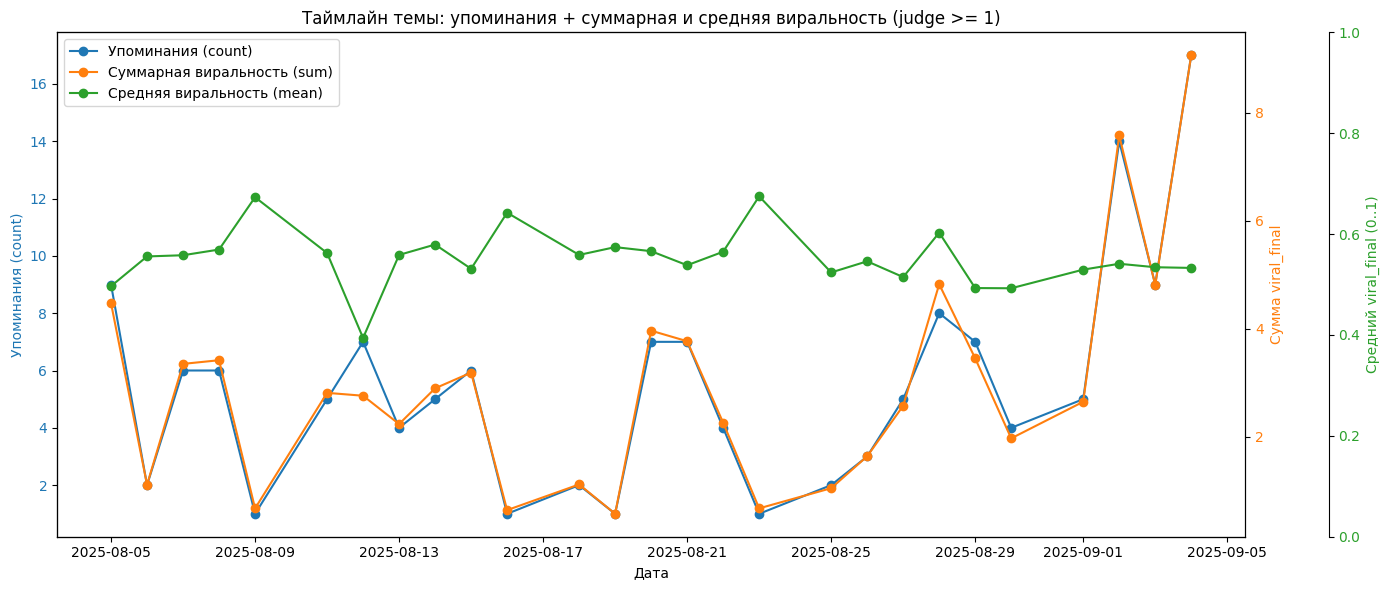

In [30]:
# %% [Cell 3-3axes] Mentions + viral_sum + viral_mean (3 разные шкалы)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))
ax = plt.gca()

# 1) Mentions (левая ось)
ax.plot(daily["date_day"], daily["mentions"], marker="o", color="tab:blue", label="Упоминания (count)")
ax.set_title(f"Таймлайн темы: упоминания + суммарная и средняя виральность (judge >= {KEEP_JUDGE})")
ax.set_xlabel("Дата")
ax.set_ylabel("Упоминания (count)", color="tab:blue")
ax.tick_params(axis="y", labelcolor="tab:blue")

# 2) Viral sum (правая ось)
ax_sum = ax.twinx()
ax_sum.plot(daily["date_day"], daily["viral_sum"], marker="o", color="tab:orange", label="Суммарная виральность (sum)")
ax_sum.set_ylabel("Сумма viral_final", color="tab:orange")
ax_sum.tick_params(axis="y", labelcolor="tab:orange")

# 3) Viral mean (третья ось справа, сдвинутая наружу)
ax_mean = ax.twinx()
ax_mean.spines["right"].set_position(("outward", 60))
ax_mean.plot(daily["date_day"], daily["viral_mean"], marker="o", color="tab:green", label="Средняя виральность (mean)")
ax_mean.set_ylabel("Средний viral_final (0..1)", color="tab:green")
ax_mean.tick_params(axis="y", labelcolor="tab:green")
ax_mean.set_ylim(0, 1)

# Общая легенда
lines = ax.get_lines() + ax_sum.get_lines() + ax_mean.get_lines()
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()


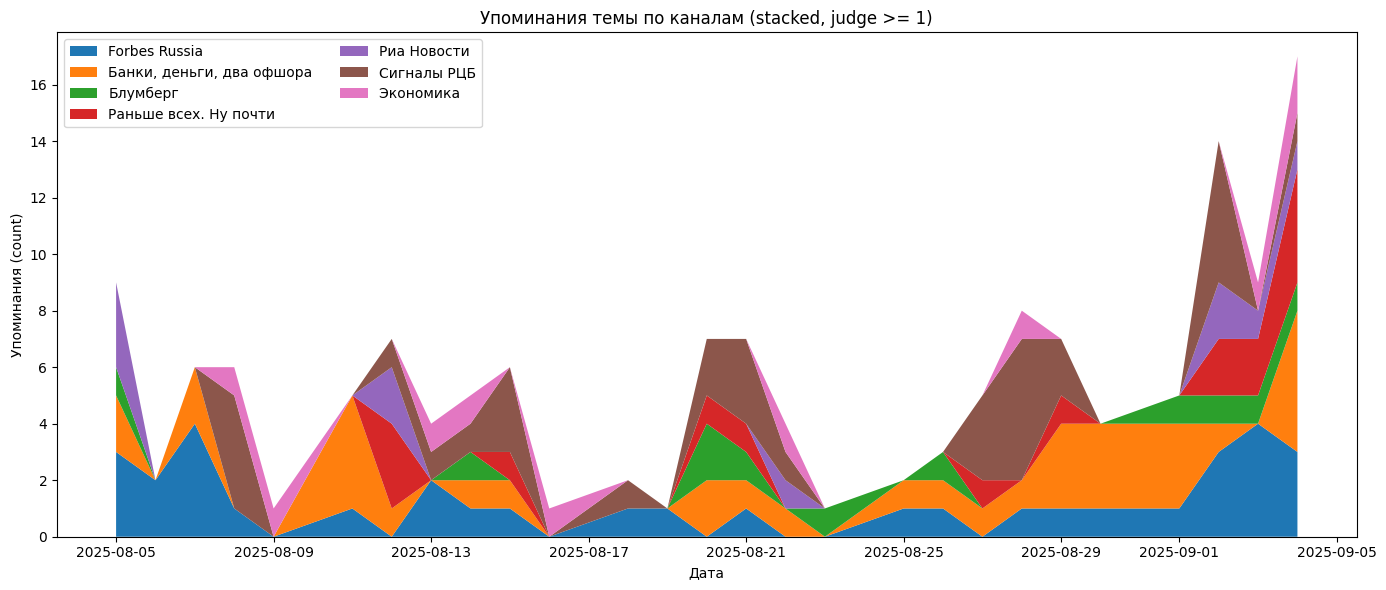

In [31]:
# %% [Cell 5] График 3: stacked area по каналам (упоминания)

fig = plt.figure(figsize=(14, 6))
ax = plt.gca()

x = pivot_mentions.index
ys = [pivot_mentions[c].values for c in pivot_mentions.columns]

ax.stackplot(x, ys, labels=list(pivot_mentions.columns))
ax.set_title(f"Упоминания темы по каналам (stacked, judge >= {KEEP_JUDGE})")
ax.set_xlabel("Дата")
ax.set_ylabel("Упоминания (count)")
ax.legend(loc="upper left", ncols=2)

plt.tight_layout()
plt.show()


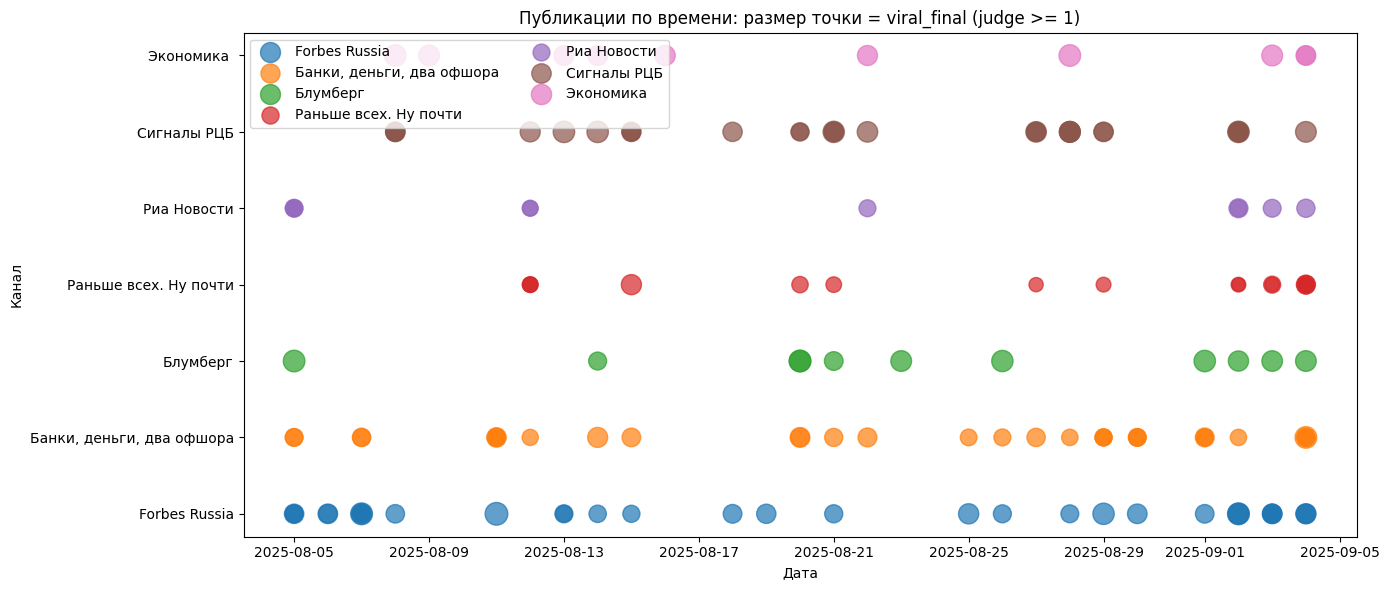

In [32]:
# %% [Cell 7] График 5: "лента постов" — scatter, размер = viral_final, Y = канал

fig = plt.figure(figsize=(14, 6))
ax = plt.gca()

channels = sorted(plot_df["channel_name"].dropna().unique().tolist())
ch_to_y = {ch: i for i, ch in enumerate(channels)}
plot_df["ch_y"] = plot_df["channel_name"].map(ch_to_y).astype(float)

# размер точки: 0..1 -> 20..320 (под постер нормально)
sizes = 20 + 300 * plot_df["viral_final"].to_numpy(dtype=float)

for ch in channels:
    sub = plot_df[plot_df["channel_name"] == ch]
    ax.scatter(sub["date_day"], sub["ch_y"], s=(20 + 300*sub["viral_final"].to_numpy(dtype=float)), alpha=0.7, label=ch)

ax.set_yticks(list(ch_to_y.values()))
ax.set_yticklabels(list(ch_to_y.keys()))
ax.set_title(f"Публикации по времени: размер точки = viral_final (judge >= {KEEP_JUDGE})")
ax.set_xlabel("Дата")
ax.set_ylabel("Канал")
ax.legend(loc="upper left", ncols=2)

plt.tight_layout()
plt.show()
